# NLP Disaster Tweets

This project specifically concerns tweets about disaster events, as disambiguated from tweets that are themselves disasters, and tweets by tweeters that might be considered disasters.

It involves classifying tweets as either discussing a real disaster event (1) or not discussing a real disaster event (0). This is a Natural Language Processing (NLP) task, which involves the application of computational techniques to the analysis and synthesis of natural language and speech.

In [1]:
import re

import nltk
import requests

# Gratuitous network request. It's popular.
response = requests.get("https://www.kaggle.com/c/nlp-getting-started/overview")
pattern = r'<meta name="og:title".*?/>'
matches = re.findall(pattern, response.text)
title = re.findall(r'content="(.+)"', matches[0])
print(f"A Kaggle Story: {title[0]}")

A Kaggle Story: Natural Language Processing with Disaster Tweets


## Data Description

The dataset provided for this competition contains a large number of tweets, each labeled as either discussing a real disaster event (1) or not (0). This is the `target` column.

In [2]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
pd.concat([df.head(), df.sample(n=5)])

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
664,959,blaze,"Tripsburg, ms.",@BabySweet420 I'm mad 420 in your name &amp; y...,0
3028,4349,earthquake,Earth,1.43 earthquake occurred near Mount St. Helens...,1
1574,2274,cliff%20fall,BestCoast,@AlexJacobsonPFS All Andre and Gore have to do...,0
5052,7201,natural%20disaster,Canada,@Cali74142290 lol natural disaster/hospital cr...,1
1022,1484,body%20bags,United Kingdom,Womens Buckle Casual Stylish Shoulder Handbags...,0


## Exploratory Data Analysis (EDA)

In this section, we will explore the dataset to get a sense of its size, structure, and other characteristics. This will involve looking at the distribution of classes (i.e., how many tweets discuss a real disaster event versus not), the word count in the tweets, and other relevant features. We will also generate several histograms and other visualizations to better understand the data.

Shape of the DataFrame: (7613, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Missing values in each column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Summary statistics:
                  id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


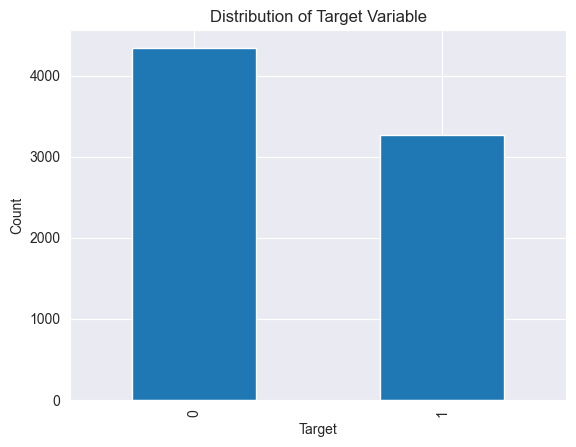


Unique values count:
 keyword      221
location    3341
dtype: int64


In [3]:
import matplotlib.pyplot as plt

print('Shape of the DataFrame:', df.shape)
print()
print(df.info())
print()
print('Missing values in each column:\n', df.isnull().sum())
print()
print('Summary statistics:\n', df.describe())
print()
df['target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()
print()
print('Unique values count:\n', df[["keyword", "location"]].nunique())


### Length of text

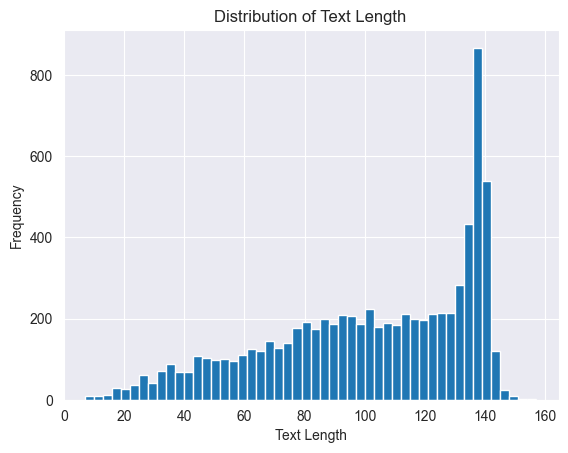

Median length: 107 characters


In [4]:
df['text_length'] = df['text'].apply(len)
df['text_length'].hist(bins=50) # Seems reasonable, given tweet length limits.
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()
print(f"Median length: {df['text_length'].median():.0f} characters")

### NaN vs Target

How does a missing `keyword` or `location` change distribution of `target`?

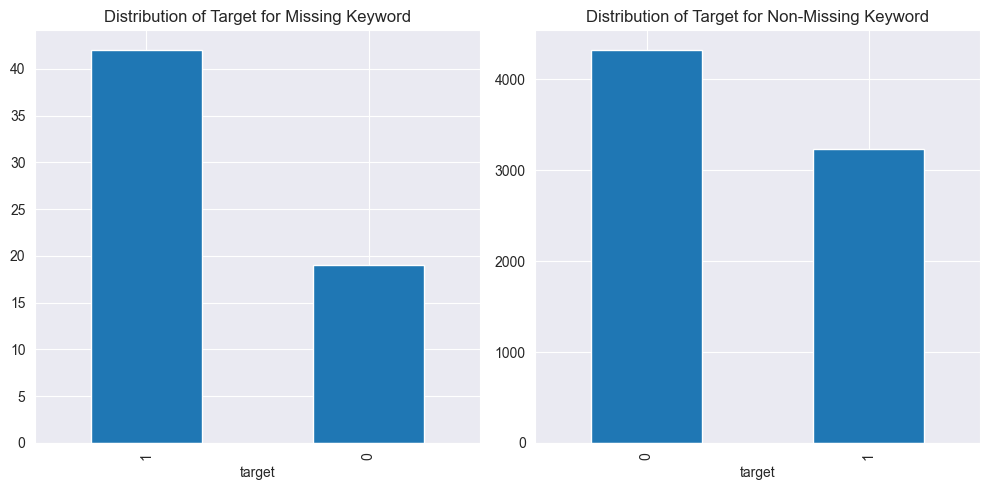

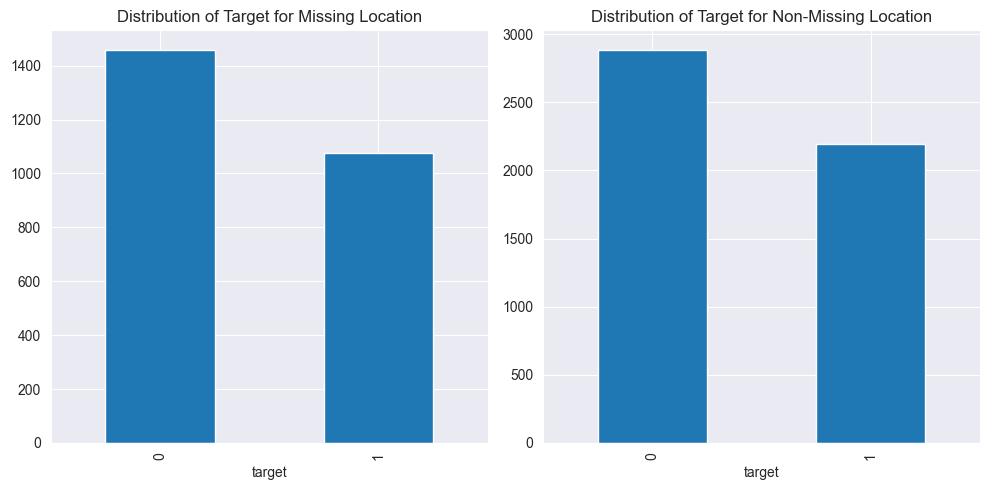

In [5]:
df['keyword_missing'] = df['keyword'].isnull()
df['location_missing'] = df['location'].isnull()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df[df['keyword_missing']]['target'].value_counts().plot(kind='bar', title='Distribution of Target for Missing Keyword')

plt.subplot(1, 2, 2)
df[~df['keyword_missing']]['target'].value_counts().plot(kind='bar', title='Distribution of Target for Non-Missing Keyword')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df[df['location_missing']]['target'].value_counts().plot(kind='bar', title='Distribution of Target for Missing Location')

plt.subplot(1, 2, 2)
df[~df['location_missing']]['target'].value_counts().plot(kind='bar', title='Distribution of Target for Non-Missing Location')

plt.tight_layout()
plt.show()

### More feature engineering

Let's gather some additional data, then plot it all against how it (linearly) correlates to our (binary) target.

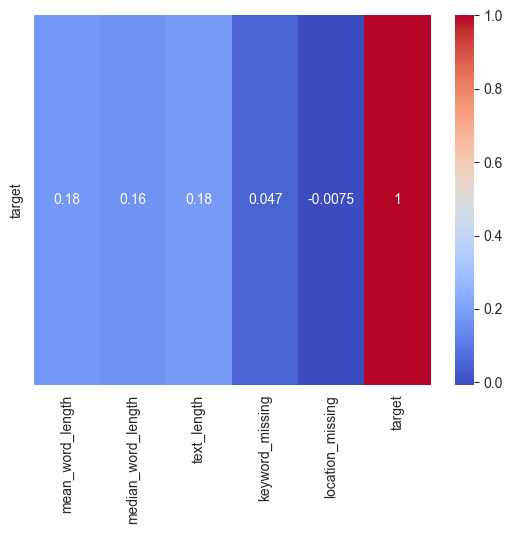

Nothing really stands out.


In [6]:
import numpy as np
import seaborn as sns

df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['median_word_length'] = df['text'].apply(lambda x: np.median([len(w) for w in str(x).split()]))

# Let's plot some stuff.
cols = ['mean_word_length', 'median_word_length', 'text_length', 'keyword_missing', 'location_missing', 'target']
corr_matrix = df[cols].corr()
sns.heatmap(corr_matrix.loc['target'].to_frame().transpose(), annot=True, cmap='coolwarm')
plt.show()

print("Nothing really stands out.")

## Data Cleaning

Before we can apply NLP techniques to the data, we need to clean it. This involves removing stop words (common words like 'the', 'is', 'and', etc. that do not contribute much information for the task at hand), and other data cleaning procedures.

In [29]:
import string
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

EMPTY_TEXT = "EMPTY"

def clean_df_text(df: pd.DataFrame) -> pd.DataFrame:
    # Normalize weirdo unicode to less-weirdo.
    df['text'] = df['text'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    # Lowercasing: Convert all the text to lower case. This avoids having multiple copies of the same words. For example, 'The' and 'the' will be considered as two different words if not converted to the lower case.
    df['text'] = df['text'].apply(lambda x: x.lower())
    # Removing Punctuation: Punctuation can provide grammatical context to a sentence which supports our understanding. But for our vectorizer which counts the number of words and not the context, it does not add value, so we remove all special characters.
    df['text'] = df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    # Removing Stopwords: Stopwords are common words that carry less important meaning than key words. We can remove them to reduce the amount of noise in our data.
    nltk.download("stopwords")
    stop = stopwords.words('english')
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    # Stemming/Lemmatization: Stemming is a process where words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix. Lemmatization is a more advanced process where word reduction is done by considering the language's vocabulary and morphological analysis of words.
    stemmer = PorterStemmer() 
    df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    # Finally, fill empty text rows with something.
    df["text"] = df["text"].replace("", EMPTY_TEXT)
    return df

df = clean_df_text(df)
pd.concat([df.head(), df.sample(n=5)])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/william/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,text_length,keyword_missing,location_missing,mean_word_length,median_word_length,tokens,text_vec,text_vec_padded
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1,69,True,True,4.384615,3.0,"[deed, reason, earthquak, may, allah, forgiv, us]","[[0.0036542, 0.005214151, -0.0029907278, 0.006...","[[0.0036542, 0.005214151, -0.0029907278, 0.006..."
1,4,NaN,NaN,forest fire near la rong sask canada,1,38,True,True,4.571429,5.0,"[forest, fire, near, la, rong, sask, canada]","[[-0.07591438, 0.0642399, 0.027223282, -0.0037...","[[-0.07591438, 0.0642399, 0.027223282, -0.0037..."
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1,133,True,True,5.090909,5.0,"[resid, ask, shelter, place, notifi, offic, ev...","[[-0.018341413, 0.0024491863, 0.007969459, -0....","[[-0.018341413, 0.0024491863, 0.007969459, -0...."
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order california,1,65,True,True,7.125000,6.5,"[13000, peopl, receiv, wildfir, evacu, order, ...","[[0.00020397612, 0.00320874, 0.007821552, -0.0...","[[0.00020397612, 0.00320874, 0.007821552, -0.0..."
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1,88,True,True,4.500000,4.0,"[got, sent, photo, rubi, alaska, smoke, wildfi...","[[-0.1277126, 0.10460915, 0.060209334, -0.0224...","[[-0.1277126, 0.10460915, 0.060209334, -0.0224..."
4389,6240,hijacking,NaN,murder stori americaua first hijack httptcocbp...,1,73,False,True,8.250000,7.0,"[murder, stori, americaua, first, hijack, http...","[[-0.12770315, 0.09995773, 0.058022622, -0.023...","[[-0.12770315, 0.09995773, 0.058022622, -0.023..."
3925,5581,flood,"Niagara Falls, Ontario",hellotybeeren cue flood peopl iron call,0,68,False,False,5.900000,4.5,"[hellotybeeren, cue, flood, peopl, iron, call]","[[0.008423304, 0.010489822, -0.0040431297, 0.0...","[[0.008423304, 0.010489822, -0.0040431297, 0.0..."
1140,1644,bombing,WorldWide,australia news japan mark 70th anniversari hir...,1,135,False,False,8.000000,6.0,"[australia, news, japan, mark, 70th, anniversa...","[[-0.020182144, 0.016848642, 0.007991578, -0.0...","[[-0.020182144, 0.016848642, 0.007991578, -0.0..."
4506,6404,hurricane,"Books Published, USA",hurrican dancer first caribbean pirat shipwrec...,0,122,False,False,6.687500,5.5,"[hurrican, dancer, first, caribbean, pirat, sh...","[[-0.044525776, 0.03722937, 0.032394335, 0.000...","[[-0.044525776, 0.03722937, 0.032394335, 0.000..."
3951,5618,flooding,"Huntsville, Alabama",1130a radar updat widespread showersstorm move...,1,131,False,False,7.800000,6.0,"[1130a, radar, updat, widespread, showersstorm...","[[0.0039495765, -0.007845499, 0.0079064695, 0....","[[0.0039495765, -0.007845499, 0.0079064695, 0...."


## Word Embedding Methods

After cleaning the data, we will convert the text data into numerical form using word embedding methods.

We could use `TfidVectorizer` or `CountVectorizer` - but these don't capture semantics.
Given that we're on Twitter (ahem... X), let's use Word2Vec as a performant embedding method that captures semantic meaning.

In [18]:
from gensim.models import Word2Vec

def df_with_vectors(df: pd.DataFrame) -> pd.DataFrame:
    df['tokens'] = df['text'].apply(lambda x: x.split())
    
    # Create a Word2Vec model
    vec_model = Word2Vec(df['tokens'], min_count=1)
    
    def text_to_vec(text):
        """Convert words to numerical representations."""
        return [vec_model.wv[word] for word in text]
    
    df['text_vec'] = df['tokens'].apply(text_to_vec)
    
    return df

df = df_with_vectors(df)
pd.concat([df.head(), df.sample(n=5)])["text_vec"]

0       [[0.0036542, 0.005214151, -0.0029907278, 0.006...
1       [[-0.07591438, 0.0642399, 0.027223282, -0.0037...
2       [[-0.018341413, 0.0024491863, 0.007969459, -0....
3       [[0.00020397612, 0.00320874, 0.007821552, -0.0...
4       [[-0.1277126, 0.10460915, 0.060209334, -0.0224...
2027    [[0.0050526913, 0.00392788, -0.008109436, -0.0...
4791    [[0.0047754333, -0.007246639, -0.0019973894, 0...
2590    [[-0.09055673, 0.069831006, 0.054790605, -0.00...
2555    [[-0.1443934, 0.104743205, 0.06958144, -0.0315...
4955    [[-0.006835477, -0.003515909, 0.0063738227, -0...
Name: text_vec, dtype: object

## Model Architecture

LSTM, or Long Short-Term Memory, is good at learning from sequences of data, where the order of the data matters. Imagine reading a book - you start from the beginning and read to the end, and the order of the words helps you understand the story. An LSTM does something similar - it can read a sequence of data (like a sentence) one piece at a time, and it keeps track of what it's seen so far to help it understand the rest.

We're choosing to use an LSTM for our model because we're working with tweets, which are short pieces of text. The order of the words in a tweet is a fundamental part of understanding its meaning. For example, the tweet "I love this product, it's not bad at all" has a positive sentiment, but if we rearrange the words to "I not love this product, it's all bad", the sentiment becomes negative. I found that exmaple on the internet.

An LSTM can "understand" this because it reads the words in order and keeps track of what it's seen. This makes it a good choice for our task of understanding the sentiment of tweets.

In [9]:
import torch
from torch import nn

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device) # Initial hidden state.
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device) # Initial cell state.
        out, _ = self.lstm(x, (h0, c0))  # LSTM returns output and (hidden state, cell state).
        out = self.fc(out[:, -1, :])  # We want the final time step output.
        return out

## Hyperparameter Tuning, Results, and Discussion

First, define our data sets.

In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

RANDOM_STATE = 35

def padded_df_vecs(df: pd.DataFrame) -> pd.DataFrame:
    max_length = max(df['text_vec'].apply(len))
    
    def pad_sequence(seq):
        if len(seq) < max_length:
            seq += [[0]*len(seq[0]) for _ in range(max_length - len(seq))]
        return seq
    
    df['text_vec_padded'] = df['text_vec'].apply(lambda x: pad_sequence(x))
    return df

df = padded_df_vecs(df)
X_train, X_test, y_train, y_test = train_test_split(df['text_vec_padded'], df['target'], test_size=0.2, random_state=RANDOM_STATE)

X_train_tensor = torch.tensor(X_train.tolist(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)
X_test_tensor = torch.tensor(X_test.tolist(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

Next, train and eval.

In [12]:
import optuna
from IPython.display import clear_output

NUM_EPOCHS = 25

def objective(trial):
    # These are the hyperparameters we'll tune.
    hidden_dim = trial.suggest_int('hidden_dim', 50, 500)
    n_layers = trial.suggest_int('n_layers', 1, 3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])

    # We need new loaders each time because we're checking batch_size too.
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # We're tuning the hyperparams by defining in terms of the optuna study.
    model = LSTMNet(input_dim=100, hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # TRAIN
    for epoch in range(NUM_EPOCHS):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

    # VALIDATE
    model.eval()
    with torch.no_grad():
        losses = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.float())
            losses.append(loss.item())
        val_loss = np.mean(losses) 
    
    return val_loss

def print_intermediate_result(_study, trial):
    clear_output()
    print(f'Trial {trial.number}\n\tvalue: {trial.value}\n\tparams: {trial.params}')

study = optuna.create_study()
study.optimize(objective, n_trials=50, callbacks=[print_intermediate_result])
study.best_params

Trial 49
	value: 0.8157114026447138
	params: {'hidden_dim': 293, 'n_layers': 2, 'lr': 0.06651338030047757, 'batch_size': 32}


{'hidden_dim': 263,
 'n_layers': 3,
 'lr': 0.00018361724458169505,
 'batch_size': 64}

## Generate and save results

We need to enter that Kaggle competition!

In [60]:
# Data.
test_df = pd.read_csv('./data/test.csv')
test_df = clean_df_text(test_df)
test_df = df_with_vectors(test_df)
test_df = padded_df_vecs(test_df)
pd.concat([test_df.head(), test_df.sample(n=5)])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/william/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,tokens,text_vec,text_vec_padded
0,0,NaN,NaN,happen terribl car crash,"[happen, terribl, car, crash]","[[-0.0032077257, 0.003540998, -0.0023310254, 0...","[[-0.0032077257, 0.003540998, -0.0023310254, 0..."
1,2,NaN,NaN,heard earthquak differ citi stay safe everyon,"[heard, earthquak, differ, citi, stay, safe, e...","[[0.003398641, -0.0005751697, 0.008610859, 0.0...","[[0.003398641, -0.0005751697, 0.008610859, 0.0..."
2,3,NaN,NaN,forest fire spot pond gees flee across street ...,"[forest, fire, spot, pond, gees, flee, across,...","[[-0.0056122877, 0.00424609, 0.006557922, -0.0...","[[-0.0056122877, 0.00424609, 0.006557922, -0.0..."
3,9,NaN,NaN,apocalyps light spokan wildfir,"[apocalyps, light, spokan, wildfir]","[[-0.010483211, -0.0052950927, -0.0069665257, ...","[[-0.010483211, -0.0052950927, -0.0069665257, ..."
4,11,NaN,NaN,typhoon soudelor kill 28 china taiwan,"[typhoon, soudelor, kill, 28, china, taiwan]","[[0.007927335, 0.002892308, -0.008321003, 0.00...","[[0.007927335, 0.002892308, -0.008321003, 0.00..."
733,2383,collapsed,"Huntsville, AL",3d view storm develop amp collaps albertvil ev...,"[3d, view, storm, develop, amp, collaps, alber...","[[0.0016615534, -0.0048739323, 0.007552883, -0...","[[0.0016615534, -0.0048739323, 0.007552883, -0..."
2666,8898,snowstorm,The Land of Make Believe,rose lofti posit transport accid oz hot air ba...,"[rose, lofti, posit, transport, accid, oz, hot...","[[-0.003409965, 0.009006951, -0.003875839, 0.0...","[[-0.003409965, 0.009006951, -0.003875839, 0.0..."
2970,9825,trauma,NYC,effect immedi maimonid medic center longer adu...,"[effect, immedi, maimonid, medic, center, long...","[[-0.0020026118, 0.0064026937, 0.009598531, -0...","[[-0.0020026118, 0.0064026937, 0.009598531, -0..."
282,917,bioterrorism,"Fargo, ND | North of Normal",studi anthrax bioterror 7 carpediem,"[studi, anthrax, bioterror, 7, carpediem]","[[-0.0031062786, -0.004179465, -0.0020407254, ...","[[-0.0031062786, -0.004179465, -0.0020407254, ..."
1612,5434,first%20responders,"Baton Rouge, LA",longer wait peopl die lafayett theater shoot f...,"[longer, wait, peopl, die, lafayett, theater, ...","[[0.0022644184, 0.00014433471, -0.007774051, 0...","[[0.0022644184, 0.00014433471, -0.007774051, 0..."


In [64]:
# Train with best params.
model = LSTMNet(input_dim=100, hidden_dim=study.best_params["hidden_dim"], output_dim=1, n_layers=study.best_params["n_layers"])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=study.best_params["lr"])

# TRAIN
train_loader = DataLoader(train_data, shuffle=True, batch_size=study.best_params["batch_size"])
losses = []  # Store loss at each epoch for a real nice chart...
for epoch in range(NUM_EPOCHS * 3):
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    clear_output()
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS * 3} - loss @ {epoch_loss:.6f}")

Epoch 75/25 - loss @ 53.752081


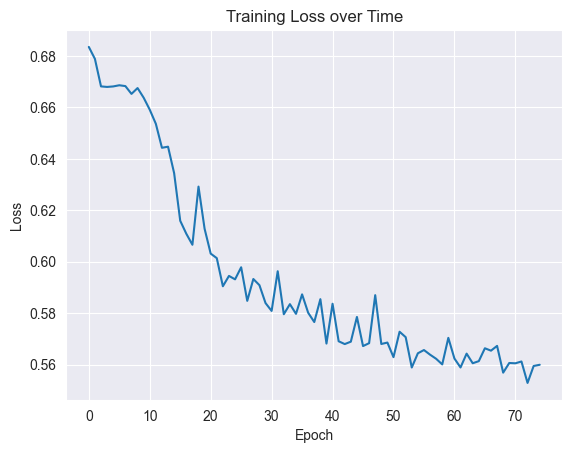

In [65]:
# Plot the loss over time.
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [82]:
# Predict and save.
X_tensor = torch.tensor(test_df["text_vec_padded"].tolist(), dtype=torch.float32)
y_tensor = torch.zeros(len(X_tensor))  # create a dummy tensor for the targets
test_data = TensorDataset(X_tensor, y_tensor)
test_loader = DataLoader(test_data, shuffle=False, batch_size=study.best_params["batch_size"])

model.eval()
outputs = []
with torch.no_grad():
    for inputs, _ in test_loader:
        output = model(inputs)
        output_s1 = torch.sigmoid(output)  # Apply sigmoid function for prediction purposes.
        output_s2 = (output_s1 > 0.5s).int()
        outputs.append(output_s2)        
outputs = torch.cat(outputs).numpy()

test_df["target"] = outputs
test_df.to_csv("./artifact/submission.csv", columns=["id","target"], index=False)

## Summary, Conclusion and Future Work

Okay! How did it go??

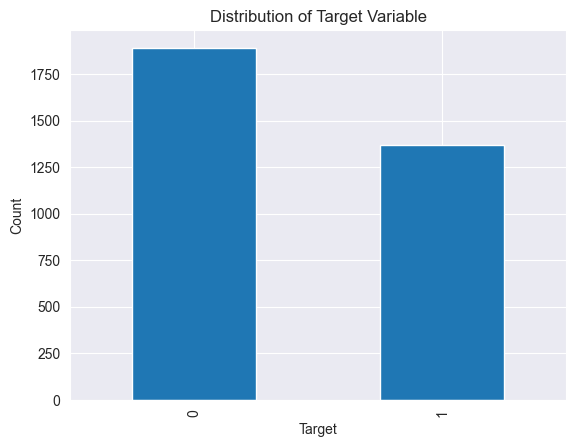

In [83]:
test_df['target'].value_counts().plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

Looks pretty normal. How did it go on Kaggle?

In [79]:
print("Kaggle gave me a 0.54 - not great")

Kaggle gave me a 0.54 - not great


There's a ton I could do to get a better score - chiefly, I could train longer than just a few epochs.

# Summary

We did EDA, trained a LSTM RNN model to classify tweets, and got rolled by Kaggle. Thanks for reading!